In [1]:
%matplotlib inline


4) Sinkhorn vs. blurred Wasserstein distances
==========================================================

Sinkhorn divergences rely on a simple idea:
by **blurring** the transport plan through the addition of
an entropic penalty, we can reduce the effective dimensionality
of the transportation problem and compute **sensible approximations of the
Wasserstein distance at a low computational cost**.



As discussed in previous notebooks, the *vanilla* Sinkhorn loop
can be symmetrized, de-biased and turned into a genuine
multiscale algorithm: available through the
:mod:`SamplesLoss("sinkhorn") <geomloss.SamplesLoss>` layer, the **Sinkhorn divergence** 

\begin{align}\text{S}_\varepsilon(\alpha,\beta)~=~ \text{OT}_\varepsilon(\alpha,\beta)
  - \tfrac{1}{2}\text{OT}_\varepsilon(\alpha,\alpha)
  - \tfrac{1}{2}\text{OT}_\varepsilon(\beta,\beta),\end{align}

is a tractable approximation of the Wasserstein distance
that **retains its key geometric properties** - positivity, convexity,
metrization of the convergence in law.

**But is it really the best way of smoothing our transportation problem?**
When "p = 2" and $\text{C}(x,y)=\tfrac{1}{2}\|x-y\|^2$,
a very sensible alternative to Sinkhorn divergences is the
**blurred Wasserstein distance**

\begin{align}\text{B}_\varepsilon(\alpha,\beta) ~=~ \text{W}_2(\,k_{\varepsilon/4}\star\alpha,\,k_{\varepsilon/4}\star\beta\,),\end{align}

where $\text{W}_2$ denotes the *true* Wasserstein distance associated to
our cost function $\text{C}$ and

\begin{align}k_{\varepsilon/4}: (x-y) \mapsto \exp(-\|x-y\|^2 / \tfrac{2}{4}\varepsilon)\end{align}

is a Gaussian kernel of deviation $\sigma = \sqrt{\varepsilon}/2$.
On top of making explicit our intuitions on **low-frequency Optimal Transport**, this
simple divergence enjoys a collection of desirable properties:

- It is the **square of a distance** that metrizes the convergence in law.
- It takes the "correct" values on atomic **Dirac masses**, lifting
  the ground cost function to the space of positive measures:

  .. math::
    \text{B}_\varepsilon(\delta_x,\delta_y)~=~\text{C}(x,y)
    ~=~\tfrac{1}{2}\|x-y\|^2~=~\text{S}_\varepsilon(\delta_x,\delta_y).

- It has the same **asymptotic properties** as the Sinkhorn divergence,
  interpolating between the true Wasserstein distance (when $\varepsilon \rightarrow 0$)
  and a degenerate kernel norm (when $\varepsilon \rightarrow +\infty$).
- Thanks to the joint convexity of the Wasserstein distance, 
  $\text{B}_\varepsilon(\alpha,\beta)$ is a **decreasing** function of $\varepsilon$:
  as we remove small-scale details, we lower the overall transport cost.

To compare the Sinkhorn and blurred Wasserstein divergences, a simple experiment
is to **display their values on pairs of 1D measures** for increasing values of 
the temperature $\varepsilon$:
having generated random samples $\alpha$ and $\beta$ 
on the unit interval, we can simply compute $\text{S}_\varepsilon(\alpha,\beta)$
with our :mod:`SamplesLoss("sinkhorn") <geomloss.SamplesLoss>` layer
while the blurred Wasserstein loss $\text{B}_\varepsilon(\alpha,\beta)$ can be
quickly approximated with the **addition of a Gaussian noise** followed
by a **sorting pass**.



Setup
---------------------
Standard imports:



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity  # display as density curves

import torch
from geomloss import SamplesLoss

use_cuda = torch.cuda.is_available()
# N.B.: We use float64 numbers to get nice limits when blur -> +infinity
dtype    = torch.cuda.DoubleTensor if use_cuda else torch.DoubleTensor

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


Display routine:



In [3]:
t_plot = np.linspace(-0.5, 1.5, 1000)[:,np.newaxis]

def display_samples(ax, x, color, label=None):
    """Displays samples on the unit interval using a density curve."""
    kde  = KernelDensity(kernel='gaussian', bandwidth= .005 ).fit(x.data.cpu().numpy())
    dens = np.exp( kde.score_samples(t_plot) )
    dens[0] = 0 ; dens[-1] = 0
    ax.fill(t_plot, dens, color=color, label=label)

Experiment
-------------



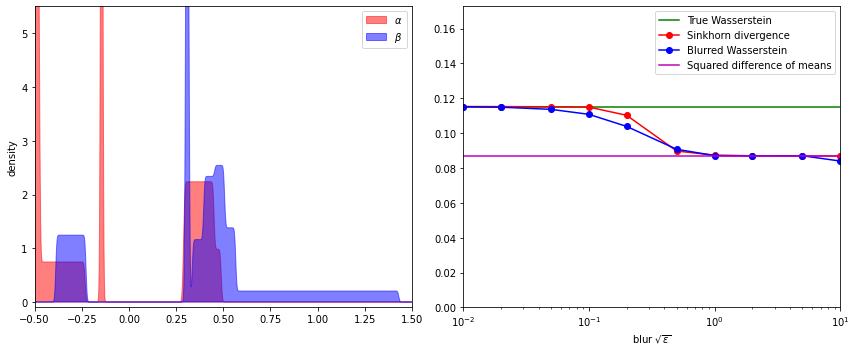

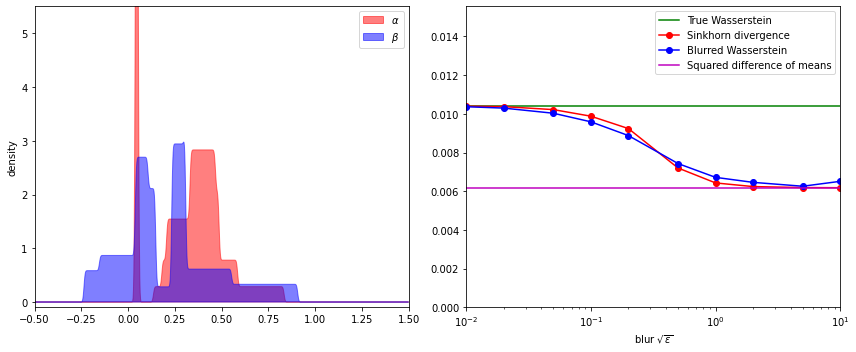

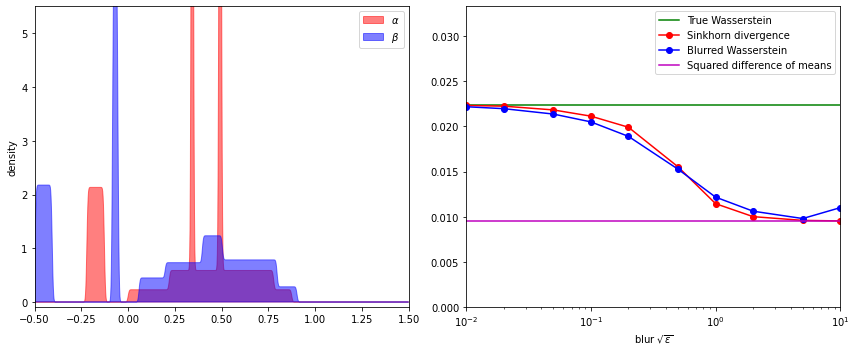

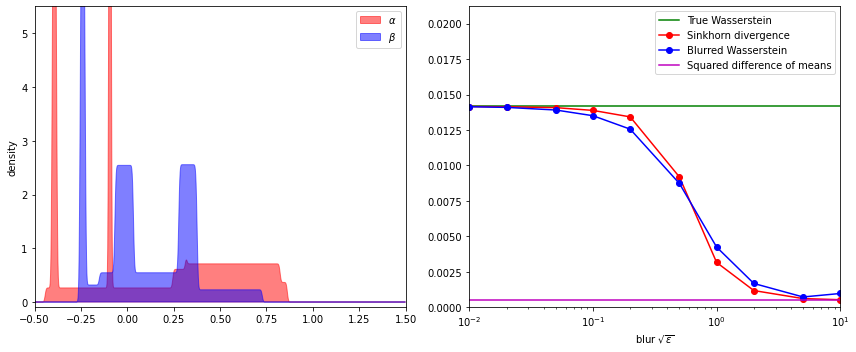

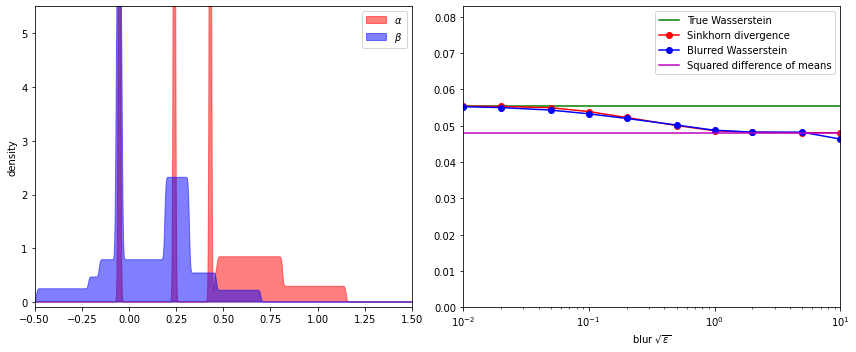

In [4]:
def rweight():
    """Random weight."""
    return torch.rand(1).type(dtype)

N = 1000 if not use_cuda else 10**3  # Number of samples per measure
C = 1000 if not use_cuda else 10000  # number of copies for the Gaussian blur

for _ in range(5):  # Repeat the experiment 5 times
    K = 5  # Generate random 1D measures as the superposition of K=5 intervals
    t = torch.linspace(0, 1, N//K).type(dtype).view(-1,1)
    X_i = torch.cat( [ rweight()**2 * t + rweight() - .5 for k in range(K)], dim=0 )
    Y_j = torch.cat( [ rweight()**2 * t + rweight() - .5 for k in range(K)], dim=0 )

    # Compute the limits when blur = 0...
    x_, _ = X_i.sort(dim=0) ; y_, _ = Y_j.sort(dim=0)
    true_wass = (.5 / len(X_i)) * ((x_ - y_)**2).sum()
    # and when blur = +infinity:
    mean_diff = .5 * (( X_i.mean(0) - Y_j.mean(0) )**2).sum()
    
    blurs = [.01, .02, .05, .1, .2, .5, 1., 2., 5., 10.]
    sink, bwass = [], []

    for blur in blurs:
        # Compute the Sinkhorn divergence:
        # N.B.: To be super-precise, we use the well-tested "online" backend
        #       with a very large 'scaling' coefficient
        loss = SamplesLoss("sinkhorn", p=2, blur=blur, scaling=.99, backend="online")
        sink.append( loss(X_i, Y_j).item() )

        # Compute the blurred Wasserstein distance:
        x_i = torch.cat( [X_i] * C, dim=0 )
        y_j = torch.cat( [Y_j] * C, dim=0 )
        x_i = x_i + .5 * blur * torch.randn(x_i.shape).type(dtype)
        y_j = y_j + .5 * blur * torch.randn(y_j.shape).type(dtype)
        x_, _ = x_i.sort(dim=0) ; y_, _ = y_j.sort(dim=0)

        wass = (.5 / len(x_i)) * ((x_ - y_)**2).sum()
        bwass.append(wass.item())

    # Fancy display:
    plt.figure(figsize=(12,5))

    if N < 10**5:
        ax = plt.subplot(1,2,1)
        display_samples(ax, X_i, (1.,0,0,.5), label="$\\alpha$")
        display_samples(ax, Y_j, (0,0,1.,.5), label="$\\beta$")
        plt.axis([-.5,1.5,-.1,5.5])
        plt.ylabel("density") ; ax.legend()
        plt.tight_layout()

    ax = plt.subplot(1,2,2)
    plt.plot([.01,10], [true_wass, true_wass], "g", label="True Wasserstein")
    plt.plot(blurs, sink,  "r-o", label="Sinkhorn divergence")
    plt.plot(blurs, bwass, "b-o", label="Blurred Wasserstein")
    plt.plot([.01,10], [mean_diff, mean_diff], "m", label="Squared difference of means")
    ax.set_xscale("log") ; ax.legend()
    plt.axis([.01, 10., 0., 1.5 * bwass[0]])
    plt.xlabel("blur $\\sqrt{\\varepsilon}$")
    plt.tight_layout() ; plt.show()

Conclusion
--------------

In practice, the Sinkhorn and blurred Wasserstein divergences
are **nearly indistinguishable**. But as far as we can tell *today*,
these two loss functions have very different properties:

- $\text{B}_\varepsilon$ is **easy to define**, compute in 1D and
  **analyze** from geometric or statistical point of views... 
  But cannot (?) be computed efficiently in higher dimensions,
  where the true OT problem is nearly intractable.
- $\text{S}_\varepsilon$ is simply available through
  the :mod:`SamplesLoss("sinkhorn") <geomloss.SamplesLoss>` layer,
  but has a weird, composite definition and is pretty **hard to**
  **study** rigorously - as evidenced by recent, technical proofs
  of `positivity, definiteness (Feydy et al., 2018) <https://arxiv.org/abs/1810.08278>`_  
  and `sample complexity (Genevay et al., 2018) <https://arxiv.org/abs/1810.02733>`_.

**So couldn't we get the best of both worlds?**
In an ideal world, we'd like to tweak the *efficient* multiscale Sinkhorn algorithm
to compute the *natural* divergence $\text{B}_\varepsilon$...
but this may be out of reach. A realistic target could be to **quantify**
**the difference** between these two objects, thus legitimizing the
use of the :mod:`SamplesLoss("sinkhorn") <geomloss.SamplesLoss>` layer
as a **cheap proxy** for the intuitive and well-understood *blurred Wasserstein distance*.

In my opinion, investigating the link between these two quantities
is one of the most interesting questions left open in the field of discrete entropic OT.
The geometric loss functions implemented in GeomLoss are probably *good enough*
for most practical purposes,
but getting a **rigorous understanding** of the multiscale, 
wavelet-like behavior of our algorithms
as we add small details through an exponential decay of 
the blurring scale $\sqrt{\varepsilon}$ would be truly insightful. 
In some sense, couldn't we prove a 
`Hilbert <https://en.wikipedia.org/wiki/Orthonormal_basis>`_-`Plancherel <https://en.wikipedia.org/wiki/Plancherel_theorem>`_
theorem for the Wasserstein distance?


